# MSE 446: Final Project - Mushroom Safety Classification
## _A Comparative Analysis of Random Forest and MLP Methods_
##### Rakin Mohammed, 20841425

## 1.0 Introduction

### 1.1 Abstract
This project compares the performance and interpretability of Random Forest (RF) and Multilayer Perceptron (MLP) algorithms for mushroom classification. The objective is to determine whether traditional machine learning ensemble methods or neural networks are more effective for this classification task. 

### 1.2 Project Focus
The scope of this project is to perform a comparative analysis of two machine learning algorithms. Machine learning algorithms have been improving at an exponential rate and have made drastic improvements to traditional statistical models that are commonly used in the real world. This rate of improvement has resulted in the development of new areas in machine learning like deep learning, which uses advanced methods for decision making using neural networks.

As such, many insights can be made by comparing traditional machine learning models with newer neural network models.   
### 1.3 Problem Statement
According to a recent study, at least 100 estimated people die every year due to mushroom poisoning. With over 14,000 different species of mushrooms, most being inedible, a resulting culture of mycology has boomed. Several communities exist online for the sole purpose of mushroom identification, with the most notable being r/ShroomID, a subreddit on Reddit.com with over 250 thousand members. The culture of foraging mushrooms has stood the test of time which proves that sharing knowledge on mushroom safety has been relevant for tens of thousands of years. 

As a result, the primary objective of this project is to classify mushrooms as edible or poisonous using physical and sensory characteristics. This classification task has significant real-world implications for mushroom foraging safety.
### 1.4 Hypothesis
Comparing the classfication performance of the RF and MLP models will result in comparable accuracies, however the RF model will have improved model interpretability and lower computational requirements compared to MLP.  

### 1.5 Importing Libraries
In the following code, we import all the libraries that will be used and accessed throughout this project. 

In [520]:
# Data Manipulation 
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset Import
from ucimlrepo import fetch_ucirepo 

# Parameter Tuning
from sklearn.model_selection import GridSearchCV

# Time Tracking
from time import time

## 2.0 Data
### 2.1 Dataset Overview
The dataset used for this project was taken from the UC Irvine Machine Learning Repository, titled "Mushroom", which has been cited in over 70 research papers. This dataset lists physical characteristics of mushrooms and classifies them as poisonous or edible. 

The dataset contains 8124 mushroom samples from 23 species of gilled mushrooms. It uses 22 categorical features and is outlined to be used for classification tasks, for making a binary classification whether a mushroom is edible or poisonous. Features include physical attributes, sensory information, and enviornmental factors. 

This dataset can be accessed using the following link: https://archive.ics.uci.edu/dataset/73/mushroom

### 2.2 Importing Dataset
The link to this dataset provides documentation for importing the dataset into Python directly using the following code.  

We store the data into feature and target dataframes, and print the head of our features to verify that the dataset was correctly imported. 

In [521]:
# Fetch dataset 
mushroom = fetch_ucirepo(id=73) 
  
# Store into dataframes
X = mushroom.data.features 
y = mushroom.data.targets 
  
# Print metadata 
X.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,w,w,p,w,o,e,n,a,g


### 2.3 Data Exploration
#### 2.3.1 Data Summary
To provide a quick and comprehensive understanding of the dataset, the following code outputs information regarding the dataset dimmensions, the list of features, and a feature summary table. The table outlines feature cardinality, missing value counts, and the most frequent values for any given feature.  

The features dataframe, X, is a 8124 x 22 matrix, and the target dataframe, y, is a 1D vector of size 8124. 

An important observation in this section is that the only feature with missing values is "stalk-root" with 2480 missing values. This will be discussed further in the Data Cleaning section. 

In [522]:
# Basic info
print("Dataset Overview:")
print(f"Number of samples: {len(X)}")
print(f"Number of features: {len(X.columns)}")
print(f"Features: {', '.join(X.columns)}")
print("Targets: ")
for column in y.columns:
    print(y[column].unique())

# Create summary table
summary_df = pd.DataFrame({
    'Feature': X.columns,
    'Unique Values': [len(X[col].unique()) for col in X.columns],
    'Most Common': [X[col].mode()[0] for col in X.columns],
    'Missing Values': [X[col].isnull().sum() for col in X.columns]
})

# Display summary table
print("\nFeature Summary:")
print(summary_df)

Dataset Overview:
Number of samples: 8124
Number of features: 22
Features: cap-shape, cap-surface, cap-color, bruises, odor, gill-attachment, gill-spacing, gill-size, gill-color, stalk-shape, stalk-root, stalk-surface-above-ring, stalk-surface-below-ring, stalk-color-above-ring, stalk-color-below-ring, veil-type, veil-color, ring-number, ring-type, spore-print-color, population, habitat
Targets: 
['p' 'e']

Feature Summary:
                     Feature  Unique Values Most Common  Missing Values
0                  cap-shape              6           x               0
1                cap-surface              4           y               0
2                  cap-color             10           n               0
3                    bruises              2           f               0
4                       odor              9           n               0
5            gill-attachment              2           f               0
6               gill-spacing              2           c             

#### 2.3.2 Feature Distribution and Visualization
Below is a frequency plot which shows the number of unique values per feature. In conjunction with the feature summary table, we get a good idea of the number of categorical values features can take on.  

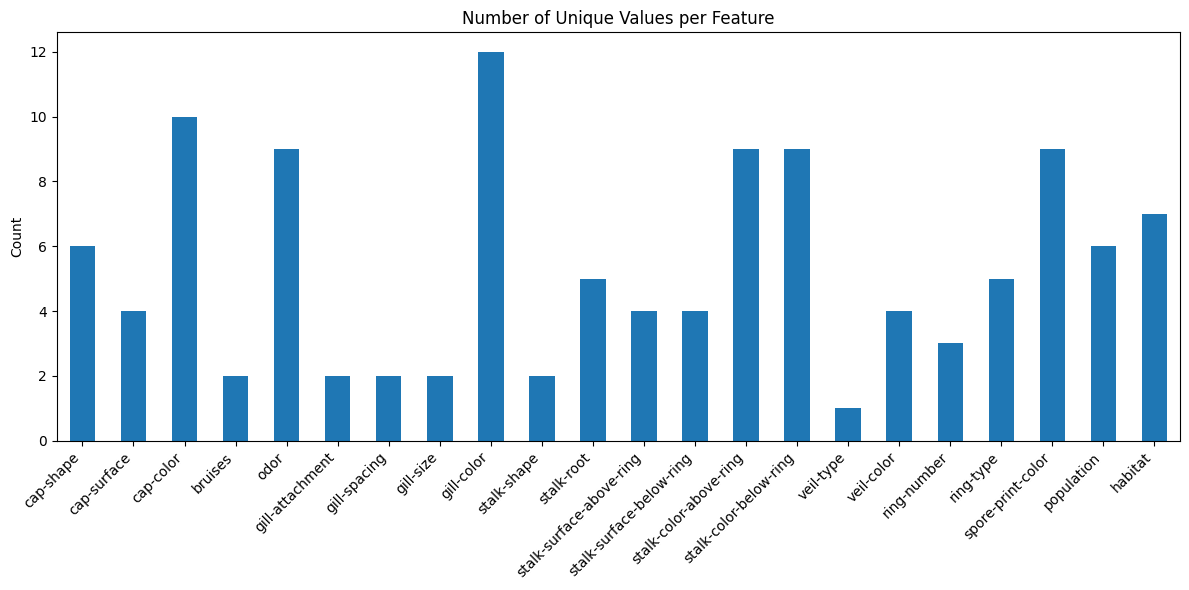

In [523]:
# Feature cardinality visualization
plt.figure(figsize=(12, 6))
feature_unique_counts = pd.Series([len(X[col].unique()) for col in X.columns], index=X.columns)
feature_unique_counts.plot(kind='bar')
plt.title('Number of Unique Values per Feature')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.tight_layout()

#### 2.3.3 Class Distribution and Visualization
Below is a histogram plot which shows the class distribution of our data. The results show that our dataset is well balanced with 51.8% of mushroom samples being poisonous and 48.2% of samples being edible. This suggests that our dataset does not need to be balanced during data processing. 

Class distribution:
poisonous
e            4208
p            3916
Name: count, dtype: int64

Class distribution percentage:
poisonous
e            51.797144
p            48.202856
Name: proportion, dtype: float64


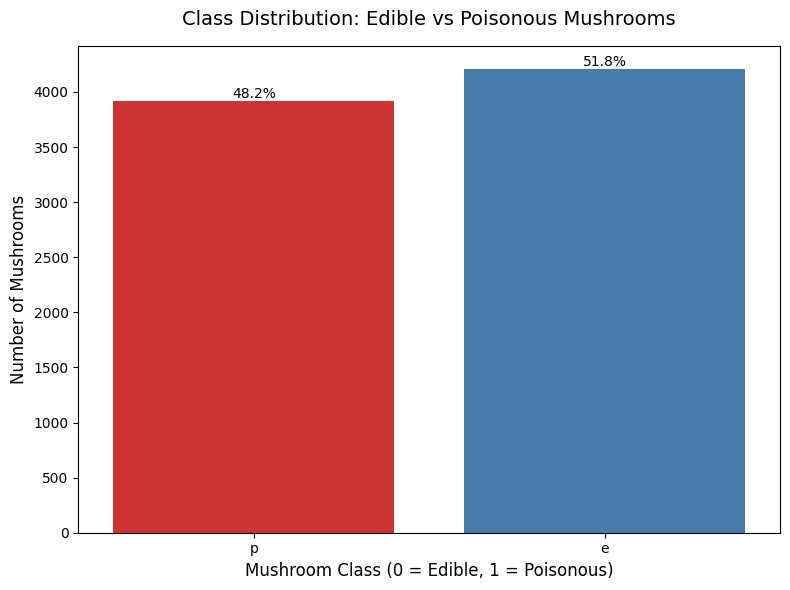

In [524]:
# Class distribution
print("Class distribution:")
print(y.value_counts())
print("\nClass distribution percentage:")
print(y.value_counts(normalize=True) * 100)

# Plot distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=pd.DataFrame(y), 
                  x='poisonous',
                  hue='poisonous',  
                  legend=False,      
                  palette='Set1')    

total = len(y)
for p in ax.patches:
    percentage = f'{(p.get_height() / total) * 100:.1f}%'
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=10, 
                color='black', 
                xytext=(0, 5),
                textcoords='offset points')

plt.title('Class Distribution: Edible vs Poisonous Mushrooms', fontsize=14, pad=15)
plt.xlabel('Mushroom Class (0 = Edible, 1 = Poisonous)', fontsize=12)
plt.ylabel('Number of Mushrooms', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()


#### 2.3.4 Feature Correlation and Visualization
To gain insight into how different features are correlated with eachother, first the categorical features must be encoded for us to work with the data.  

Below is a feature correlation matrix representing the relationships between features. Key observations from the heatmap are summarized below. 

Strong Correlation Feature Pairs: 
    - "veil-color" and "gil-attachment": 0.9
    - "bruises" and "ring-type": 0.69
    - "gil-color" and "ring-type": 0.63
    - "gil-size" and "spore-print-color": 0.62

Weak Correlation Feature Pairings: 
    - Cap features (color, shape, surface) have low correlation with other features
    - Population and habitat show very weak correlations with other features
    - Many feature pairs show correlations near 0 which implies independence 

Additional patterns we observe are that stalk-related features generally tend to correlate with one another. Similarly, the gill-related features also show some correlation with one another.  

An important observation in this section is that the rows and columns associated with "veil-type" are strictly blank or missing. This will be discussed further in the Data Cleaning section. 

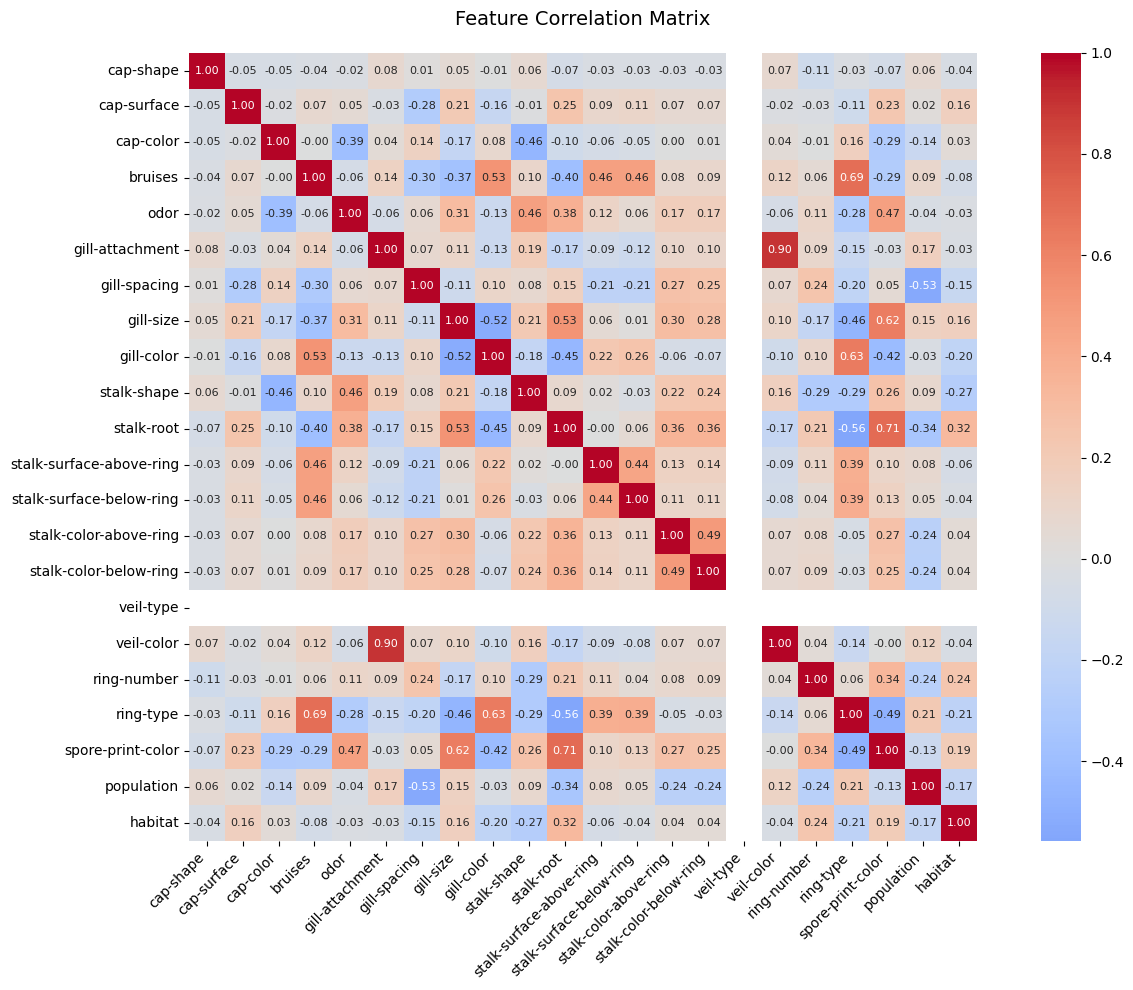

In [525]:
# Encode features
label_encoders = {}

for column in X.columns:
    le = LabelEncoder()
    X.loc[:, column] = le.fit_transform(X[column].astype(str))
    label_encoders[column] = le


plt.figure(figsize=(14, 10))  

# Calculate correlation matrix
corr_matrix = X.corr()

# Heatmap
sns.heatmap(corr_matrix,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            center=0,
            square=True, 
            annot_kws={'size': 8},
            xticklabels=X.columns,
            yticklabels=X.columns)

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.title('Feature Correlation Matrix', pad=20, fontsize=14)
plt.tight_layout()
plt.show()

### 2.4 Data Cleaning
From our data exploration section, we found that our dataset was considerably well balanced and clean with almost no issues. However, some data preprocessing has to be done. 

First, note that 21 out of the 22 features have no missing values with only one anomaly. The "stalk-root" feature is missing 2480 values out of 8124, which is approximately 30% of values being missing. Since such a large number of data is missing, it would be most appropriate to remove this feature from our dataset. 

The disrepency in missing values for the "stalk-root" feature can be easily explained. Consider that stalk root information can only be documented by pulling the mushroom out from the ground, which makes this feature impractical. If a mushroom was poisonous, it would be recommended to not touch it, and so the process for extracting information for this feature is counterintuitive in terms of mushroom safety. Therefore, we will remove this feature entirely leaving us with 21 features, as the rest of the dataset is clean. 

Second, note that from the feature correlation matrix we found that one of the features were missing with blank values, which was the "veil-type" feature. This can be explained by referencing our feature cardinality histogram which shows that veil type has only possible value (p).  This results in a constant column of 0s after encoding our features, which results in there being no correlation with other variables. Since all species of mushrooms in the dataset will always share the same value "p" for its "veil-type" feature, this feature provides no value for our classification problem. As a result, this feature will be removed as well. 

The following code removes the features "veil-type", for being a constant value, and "stalk-root", for having missing values, from the dataset. This means we will now be working with 20 features. 

In [526]:
# Remove stalk-root feature
X = X.drop('stalk-root', axis=1)

# Verify 
print("Updated feature count:", len(X.columns))
print("Remaining features:", X.columns.tolist())

# Remove veil-type feature
X = X.drop('veil-type', axis=1)

# Verify 
print("\nUpdated feature count:", len(X.columns))
print("Remaining features:", X.columns.tolist())

Updated feature count: 21
Remaining features: ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']

Updated feature count: 20
Remaining features: ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']


### 2.5 Data Preprocessing
In an earlier section, we had to encode our features in order to visualize the correlation between features. In this section, we perform the same process to encode our targets as well, with edible being mapped to 0, and poisonous mapped to 1. 

In this section, we also split our data into train/test for validation purposes, and scale our data which will be required for our MLP model.

In [527]:
# Encode targets
le_target = LabelEncoder()
y = le_target.fit_transform(y.values.ravel())

# Verify 
print("Unique encoded target values:", np.unique(y))
print("\nEncoding mapping:", dict(zip(le_target.classes_, le_target.transform(le_target.classes_))))

Unique encoded target values: [0 1]

Encoding mapping: {'e': np.int64(0), 'p': np.int64(1)}


In [528]:
# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Ensure balanced split of edible/poisonous 
)

# Verify split sizes
print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

# Scale features (req. for MLP only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

Training set size: 6499
Testing set size: 1625
X_train_scaled shape: (6499, 20)
X_test_scaled shape: (1625, 20)


## 3.0 Models
### 3.1 Overview of Chosen Algorithms
**Random Forest**
Random Forest is an ensemble machine learning method that operates by constructing multiple decision trees during training by selecting random subsets of data and features. Each tree independently makes predictions by splitting data based on feature values. A final prediction is made with a majority vote done across all trees. 

The RF algorithm uses feature randomization and bootstrap sampling to reduce overfitting. RF is also able to perform feature importance calculations while traversing through its tree structure. 

**Multilayer Perceptron**
MLP is a feedforward deep learning neural network that maps input features to target classifcations. The model has an input layer with a number of nodes equal to the number of features, or 20 in our case, and an output layer with nodes corresponding to the number of targets, which is 2 in our case. There is also a single hidden layer with some number of nodes that is determined during paramter tuning. The model uses backpropogation for learning feature patterns. 

The MLP algorithm uses the ReLU activation function for non-linear transformations and the Adam optimizer for weight updates.

**Key Differences**
1. Decision Making Process: 
    RF makes feature-based decisions through tree paths, while MLP uses complex weight adjustments and non-linear transformations. 

2. Model Structure: 
    RF uses a collection of independent decision trees, whereas MLP ses a single network with interconnected layers of neurons.

3. Feature Type:
    RF can handle categorical features, while MLP requires scaled numerical inputs

4. Training: 
    RF trains by constructing trees in parallel with random feature sampling, while MLP uses sequential weight optimization through gradient descent.  

### 3.2 Parameter Tuning Methodology
**Random Forest Parameters**
1. **n_estimators**: Number of trees
2. **max_features**: Features considered per split
3. **min_samples**: Minimum samples per split
4. **max_depth**: Tree depth limit
5. **min_samples_leaf**: Minimum samples per leaf

**MLP Parameters**
1. **hidden_layer_sizes**: Number of nodes in hidden layer
2. **activation**: Activation function for transforming hidden layer output
3. **learning_rate_init**: Step-size for amount of weights updated during training
4. **max_iter**: Total number of training iterations

**Methodology**
To systematically optimize our parameters for both models, we will use Grid Search implentation. Grid search tests every possible combination of paramaters in conjunction with k-fold cross-validation to determine the optimal parameters by comparing cross validation scores. Using the same paramater tuning methodology for both models ensures that our evaluation methods remain consistent.  

Grid search was chosen over other options due to our small dataset size of 8124 samples which makes it practical to test every parameter combination. This approach ensures that we find optimal parameters in a reproducible manner, which is critical for our application of classifying mushroom safety.  

As such, grid search was the best option for our project requirements as it is easy to implement for small datasets and low number of parameters. 

### 3.3 Evaluation Metrics and Testing Framework
The evaluation metrics chosen to measure and compare the performances of our models ae listed and justified as follows.

1. **Accuracy**: 
    This metric is critical as it measures overall correct predictions, which is necessary for a sensitive application like classifying mushroom safety. This metric is also reasonable given our balanced dataset. 

2. **Precision**:
    This metric measures the accuracy of positive predictions which is highly relevant to the project problem, as false positives must be avoided at all costs (misidentifying poisonous as edible).

3. **Recall**: 
    This metric measures the ability to predict all positive cases, which similarly helps prevent misclassifications. 

4. **F1 Score**:
    This metric balances precision-recall trade-off and summarizes them, making it a great metric to compare ML models. 

5. **Training Time**:
    This metric helps us measure computational efficiency and model complexity. This is relevant for considering the practicality of implementation of our models. 

For our testing framework, we use both K-fold Cross-Validation as well as a Train/Test Split to validate our models thoroughly. K-fold cross-validation provides great estimates for performance and validates consistency across different data splits. K-fold cross-validation also helps detect overfitting and can provide reports on mean accuracy and standard deviation. We also employ a train/test split such that we have an independent test set for our final validation.     

    
### 3.4 Random Forest Implementation 
First we setup the RF model and create a parameter grid with various options. The model then uses grid search to determine the best parameters for our model. 

From the output of the code, we get the following list of optimal parameters: 
            {'max_depth': None, 
            'max_features': 'sqrt', 
            'min_samples_leaf': 1, 
            'min_samples_split': 2, 
            'n_estimators': 50}

From these parameters, we can note that a small number of trees (50) is sufficient for this problem. Additionally, we allow the model to traverse through the entire tree and have minimal restrictions on leaf size and splitting threshold. Using "sqrt" for sampling features at each node split introduces randomness which helps to reduce correlation. 

These parameters suggest the model can achieve good performance with simple settings, and are used to train and evaluate the RF model. 


In [529]:
# RF Setup
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

# Setup Grid Search parameters
rf_param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(
    rf_model,
    rf_param_grid,
    cv=5,
    n_jobs=-1,
    verbose = 1
)

# Fit model using training data
print("Tuning RF Parameters...")
rf_grid.fit(X_train, y_train)

print("\nBest RF Parameters:", rf_grid.best_params_)

Tuning RF Parameters...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best RF Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


c:\Waterloo\4A\MSE 446\ML Project\.venv\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [530]:
# Train RF w/ best parameters
rf_final = RandomForestClassifier(
    n_estimators=50,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    max_depth=None,
    random_state=42
)

rf_final.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

### 3.5 MLP Implementation
First we setup the MLP model and create a parameter grid with various options. The model then uses grid search to determine the best parameters for our model. 

From the output of the code, we get the following list of optimal parameters: 
             {'activation': 'relu', 
             'hidden_layer_sizes': (50,), 
             'learning_rate_init': 0.01, 
             'max_iter': 200}

From these parameters, we can note that a small network (50 nodes in hidden layer) is sufficient for our problem. Our learning rate of 0.01 is relatively high, but over all this suggests that the problem is not very complex with strong predictive features. 

Both models found optimal parameters that favour simplicity which is ideal for avoiding overfitting and maintaining model interpretability and computational efficiency.

These optimal parameters are used to train the evaluate the MLP model. 

In [531]:
# MLP Setup 
mlp_model = MLPClassifier(
    solver='adam',
    random_state=42
)

# Setup Grid Search parameters
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [200]
}

mlp_grid = GridSearchCV(
    mlp_model,
    param_grid=mlp_param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
print("Tuning MLP parameters...")
mlp_grid.fit(X_train_scaled, y_train)

print("\nBest MLP Parameters:", mlp_grid.best_params_)

Tuning MLP parameters...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best MLP Parameters: {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01, 'max_iter': 200}


In [532]:
# Train MLP w/ best parameters
mlp_final = MLPClassifier(
    hidden_layer_sizes=(50,),
    activation='relu',
    learning_rate_init=0.01,
    max_iter=200,
    solver='adam',
    random_state=42
)

mlp_final.fit(X_train_scaled, y_train)

MLPClassifier(hidden_layer_sizes=(50,), learning_rate_init=0.01,
              random_state=42)

## 4.0 Results
### 4.1 Performance Evaluation
Using our outlined testing framework, the following code computes the evaluation metrics for both models using 5-fold cross-validation. A classification report and summary of evaluation metrics are provided for both models. 

In [533]:
# Model Evaluation Function w/ k-fold cross-validation and 80/20 train/test set
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Training time measurement
    start_time = time()
    
    # k-fold cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    
    # Train model on full training set
    model.fit(X_train, y_train)
    train_time = time() - start_time
    
    # Predictions on test set
    y_pred = model.predict(X_test)
    
    # Performance metrics
    results = {
        'Model': model_name,
        'Cross Validation Accuracy (mean)': cv_scores.mean(),
        'Cross Validation Accuracy (std)': cv_scores.std(),
        'Test Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'Training Time': train_time
    }
    
    # Display classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_pred))
    
    return results, model

# Cleanly print performance metrics
def print_model_results(results):
    print(f"\nResults for {results['Model']}:")
    print("-" * 40)
    print(f"Cross Validation Accuracy: {results['Cross Validation Accuracy (mean)']:.4f}")
    print(f"Cross Validation Std: {results['Cross Validation Accuracy (std)']:.4f}")
    print(f"Test Accuracy: {results['Test Accuracy']:.4f}")
    print(f"Precision: {results['Precision']:.4f}")
    print(f"Recall: {results['Recall']:.4f}")
    print(f"F1 Score: {results['F1 Score']:.4f}")
    print(f"Training Time: {results['Training Time']:.4f} seconds")

In [534]:
# Evaluate RF Model 
rf_results, rf_final = evaluate_model(rf_final, X_train, X_test, y_train, y_test, "Random Forest")
print_model_results(rf_results)


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625


Results for Random Forest:
----------------------------------------
Cross Validation Accuracy: 1.0000
Cross Validation Std: 0.0000
Test Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Training Time: 0.8694 seconds


In [535]:
# Evaluate MLP Model
mlp_results, mlp_final = evaluate_model(mlp_final, X_train_scaled, X_test_scaled, y_train, y_test, "MLP")
print_model_results(mlp_results)


Classification Report for MLP:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625


Results for MLP:
----------------------------------------
Cross Validation Accuracy: 1.0000
Cross Validation Std: 0.0000
Test Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Training Time: 1.9890 seconds


#### 4.1.1 Classification Visualization
The following code generates confusion matrices for both models to visually interpret their classification reports. 

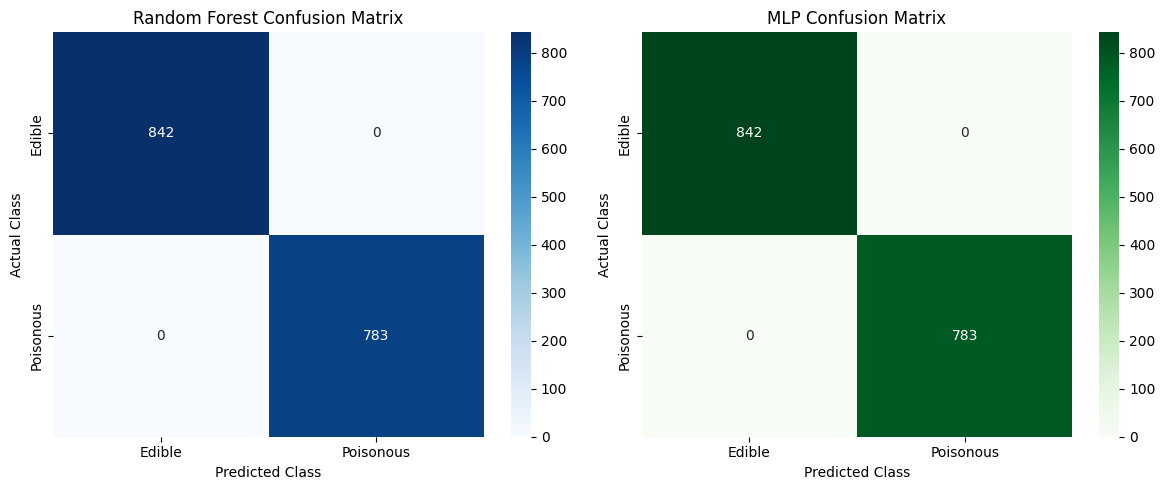

In [536]:
# Confusion matrix visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Class labels
class_labels = ['Edible', 'Poisonous']

# RF confusion matrix
cm_rf = confusion_matrix(y_test, rf_final.predict(X_test))
sns.heatmap(cm_rf, annot=True, fmt='d', ax=ax1, cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
ax1.set_title('Random Forest Confusion Matrix')
ax1.set_xlabel('Predicted Class')
ax1.set_ylabel('Actual Class')

# MLP confusion matrix
cm_mlp = confusion_matrix(y_test, mlp_final.predict(X_test_scaled))
sns.heatmap(cm_mlp, annot=True, fmt='d', ax=ax2, cmap='Greens',
            xticklabels=class_labels, yticklabels=class_labels)
ax2.set_title('MLP Confusion Matrix')
ax2.set_xlabel('Predicted Class')
ax2.set_ylabel('Actual Class')

plt.tight_layout()
plt.show()

#### 4.1.2 Interpreting 
From the confusion matrices above, both models show 842 true negatives (edible), 783 true positives (poisonous), and 0 false positives and false negatives. This confirms that the models are able to clasify mushrooms into either edible or poisonous categories with perfect accuracy. This result is critical in applications where false negatives could to lead to dangerous misclassifications. 

Continuing, we find that both models achieved perfect performance across all metrics, reflecting the ability of our models to perfectly classify mushrooms. These scores demonstrate that both models are effective in classifying mushrooms, especially given our balanced test set. 

Despite most performance metrics were identical, the training times for the two models were not. The training time for the RF model was approximately 1.25 seconds, while the MLP model took 2.99 seconds. While this difference may not seem significant, the difference in training times may increase as the dataset size grows, indicating that RF may be the better option in terms of scalability for large datasets. 

While the perfect performance metrics may come as a surprise, it could be argued that this outcome is to be expected as the mushroom classifcation problem is outlined using clear and distinctive features documented by mycologists. Additionally, our feature correlation matrix did show strong relationships between many features which support this argument. The UCI mushroom dataset was also very clean and well-balanced, requiring minimal data cleaning which may be an indicator of why it has been used in countless studies.  

It is important to note that both models performing identically may be a result of our paramater tuning methodology. Grid search was used for both models to exhaustively determine the best parameters. This may suggest that our approach increased model complexity. Given that both models achieved perfect accuracy despite relatively simple implementation, it is recommended to reduce complexity of paramaters further to reflect a simpler system. For example, we should reduce the number of trees used for RF and the number of nodes used for MLP. Also, the RF model is using unlimited depth, and similarly the MLP has a very high learning rate of 0.01, which may be factors contributing to these results. 

Overall, even though it is important to consider model complexity for practical applications, we believe that our methodology was justified. Given the dataset's clear classification boundaries and strong feature relationships, the perfect performance of our models likely reflects the inherent seperability of mushroom classes rather than overfitting or data leakage. 

### 4.2 Model Interpretability Comparison
From the previous section, we concluded that both models achieved perfect accuracy with no obvious differences in performance. This aligns with the first half of our hypothesis that both models would perform accurately for mushroom classification. In this section, we will discuss and explore the second half our hypothesis that the two models will differ in interpretability and complexity 

To compare the interpretability of our two models, we will have to take slightly different approaches for both. 

For the RF model, we can calculate feature importance scores directly, which can be used to interpret how the model makes decisions. This can be done as the Random Forest algorithm tracks which features contribute the most in selecting a decision,with feature importance being calculated based on how often that feature is used to split data. As a result, RF models are highly interpretable. 

The MLP model on the other hand is not nearly as interpretable. MLP uses neural networks to capture complex and non-linear relationships, effecitvely acting as a black-box. Additionally, the weights assigned between layers does not directly translate into some form of feature importance like in RF. This makes feature important analysis difficult for MLP models. 

To approach this, we will perform weight pattern analysis for our MLP model to extract as much insight as possible.

The following code generates plots for the RF model's feature importance analysis and the MLP model's feature weight analysis. 

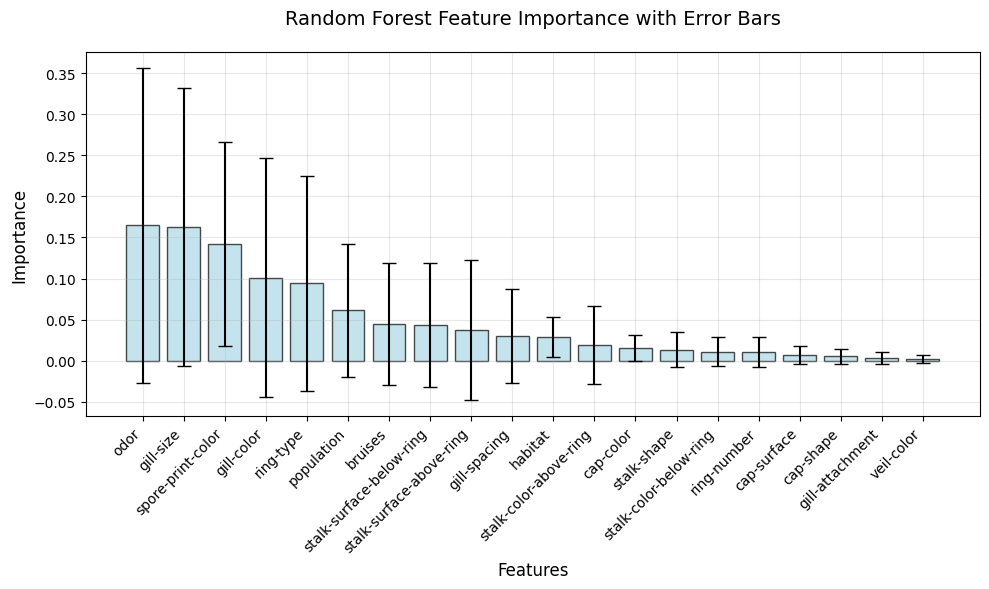

In [537]:
# Visualize RF feature importance (w/ error bars to show variability)
importances = rf_final.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_final.estimators_], axis=0)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), feature_importance['importance'], 
        yerr=std[feature_importance.index],
        capsize=5,
        color='lightblue',
        edgecolor='black',
        alpha=0.7)
plt.xticks(range(len(importances)), feature_importance['feature'], rotation=45, ha='right')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.title('Random Forest Feature Importance with Error Bars', fontsize=14, pad=20)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


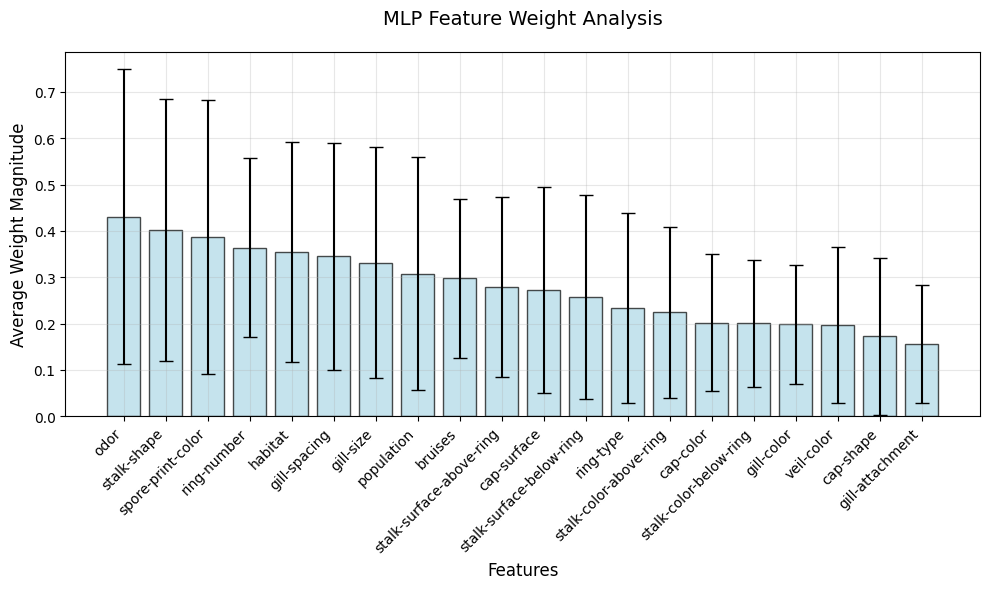

In [538]:
# Analyze MLP weights
weights = mlp_final.coefs_[0]
feature_weights = np.abs(weights).mean(axis=1)
weight_std = np.abs(weights).std(axis=1)
weight_importance = pd.DataFrame({
    'feature': X.columns,
    'weight': feature_weights
}).sort_values('weight', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_weights)), weight_importance['weight'],
        yerr=weight_std[weight_importance.index],
        capsize=5,
        color='lightblue',
        edgecolor='black',
        alpha=0.7)
plt.xticks(range(len(feature_weights)), weight_importance['feature'], rotation=45, ha='right')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Average Weight Magnitude', fontsize=12)
plt.title('MLP Feature Weight Analysis', fontsize=14, pad=20)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**RF Feature Analysis Results**: 

The top five most important features were Odor, Gill-size, Spore-print-color, Gill-color, and Ring-type. These define features that are the strongest predictors for mushroom safety. The least important features (all with importance of <0.02) were Cap-surface, Cap-shape, Gill-attachment and Veil-color. 

This analysis on the RF model shows a clear importance heirarchy ranging from 0 to 0.16. We can also see small error bars for insignificant features which have minimal impact of decision outcomes. Only 5-6 features have significant importance of >0.05. 

**MLP Weight Analysis Results**: 

The top five most important features were Odor, Stalk-shape, Spore-print-color, Ring-number, and Habitat. The MLP model and RF model both attributed significance to odor and spore print color, but the MLP model put more emphasis on features such as  Stalk-shape, ring-number, and habitat. 

This analysis shows a more even distribution with weight magnitudes ranging from 0.15 to 0.42. We can observe larger error bars across all features, with most of all our features being used to contribute to decisions.  

**Comparison**: 
Comparing these results, we find both the RF and MLP model identified odor and spore print color as the most significant features. This suggests that these features are universally significant to this problem. However, MLP assigns higher importance to structural features such as stalk shape and ring number, whereas RF emphasized gill characteristics more heavily.   

This comparison highlights the difference in approaches for determing feature importance between traditional machine learning models, demonstrated using RF, and neural networks, demonstrated through MLP, despite both achieving perfect accuracies for mushroom classification. 

### 4.3 Model Complexity Comparison
To briefly comment on the complexities of both models, we can contrast the structural components of our models. 

The RF model takes decision paths focusing only on the most significant features. The decision-making process is also simple using tree traversal. The clear feature importance heirarchy as discussed in the previous section also helps to reduce model complexity. And overall, the RF model has lower computational requirements which are reflected by its low training time. 

For the MLP model, all features actively contribute towards making a classification prediction. The MLP algorithm also uses complex weight interactions between features instead defining clear feature importances. This results in more uncertainty when attempting to perform feature importance analysis on the model for interpretation. And overall, given the MLP model is a neural network, the computational requirements are much higher than traditional machine learning methods.  

In conclusion, RF offers lower complexity as it only requires a few significant features to make decisions. We have also found that the feature importance heirarchy shows low variaiblity, making the model's decision process easy to interpret and understand. RF also is less computationally intensive than MLP. 

This concludes comparison of the two models and confirms that while both RF and MLP models perform well for mushroom classification, the RF model is advantageous to implement due to better model interpretability and lower complexity.

## 5.0 Conclusions
### 5.1 Summary
This project evaluated two machine learning models, Random Forest (RF) and Multi-layer Perceptron (MLP), for classifying mushrooms as edible or poisonous using the UCI Mushroom dataset. Both models demonstrated perfect classification performance, achieving 1.0 for accuracy, precision, recall, and F1 scores. Key features such as Odor and Spore Print Color were identified as critical for classification by both models. However, the RF model provided better interpretability through feature importance analysis, while the MLP model revealed distributed feature signficances with higher overall complexity.   

### 5.2 Real World Applications  
Mushroom classification is high relevant in real-world applications, as the ability to accurately distinguish between and poisonous mushrooms is critical for ensuring public safety. In communities where foraging is common, an automated machine learning system that classifies mushroom safety could save lives and help educate countless people on safe practices. Additionally, similar systems can be adapted for broader agricultural applications, such as identifying crop diseas or assesing produce quality.  

### 5.3 Recommendations
Based on our comparative analysis of the two models, it is recommended to use the RF model for future iterations of this project. This is due to its ease of implementation, low computational complexity, and high interpretability while maintaing comprable performance to the MLP model. 

Additionally, it is recommended to expand on this work by testing on larger datasets with more noise. This would allow for a more insightful assesment of model scalability and performance, as the UCI mushroom dataset was relatively small yet exceptionally well defined. It is also recommended to implement additional data augmentation techniques to simulate real-world variances in mushroom features. 

The final recommendation is to extend this project with image classification techniques to determine mushroom safety. This project uses a dataset based on well documented field notes published by renowned mycologists, which is not the case in practice. An image classification model could be deployed as a mobile or web app to perform real-time classification, which would greatly improve the usability of this project's findings. 

## 6.0 References 

https://archive.ics.uci.edu/dataset/73/mushroom

https://kjis.journals.ekb.eg/article_327330_afd343addc365a1440bbf1bf24d683bf.pdf

https://www.biorxiv.org/content/10.1101/2022.08.31.505980v1.full.pdf

https://www.r-bloggers.com/2017/01/random-forest-classification-of-mushrooms/

https://www.nature.com/articles/s41598-021-87602-3

https://weekly.chinacdc.cn/article/doi/10.46234/ccdcw2020.005?pageType=en#:~:text=But%20with%20the%20utilization%20of,China%20(2%2D5)